# Basic illustration of several algorithms

In [1]:
from time import time

import blackjax
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from jax.flatten_util import ravel_pytree
from matplotlib.gridspec import GridSpec

from pbnn.deep_ensembles import deep_ensembles_fn
from pbnn.map_estimation import train_fn
from pbnn.mcdropout import mcdropout_fn
from pbnn.mcmc.hamiltonian import hmc, sghmc, sghmc_cv, sghmc_svrg
from pbnn.mcmc.langevin import (
    cyclical_sgld,
    pSGLD,
    sgld,
    sgld_cv,
    sgld_svrg,
)
from pbnn.swag import swag_fn
from pbnn.utils.analytical_functions import gramacy_function
from pbnn.utils.plot import plot_on_axis

%load_ext watermark

### Generate data

In [2]:
n = 100
noise_level = 0.1

np.random.seed(0)
X = 20 * np.random.rand(n, 1)
X_test = np.linspace(0, 20, 200)[:, None]
X, X_test = jnp.array(X), jnp.array(X_test)

noise, noise_test = (
    np.random.randn(n, 1) * noise_level,
    np.random.randn(len(X_test), 1) * noise_level,
)

y = gramacy_function(X, noise)
y_test = gramacy_function(X_test, noise_test)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Define the network, loglikelihood and logprior 

In [3]:
# define loglikelihood et logprior
class network(nn.Module):
    """Simple MLP."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=50,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=50,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=1,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        return x


def loglikelihood_fn(parameters, data, sig_noise: float = noise_level):
    """Gaussian log-likelihood"""
    X, y = data
    return -jnp.sum(
        0.5 * (y - network().apply({"params": parameters}, X)) ** 2 / sig_noise**2
    )


def logprior_fn(parameters):
    """Compute the value of the log-prior density function."""
    flat_params, _ = ravel_pytree(parameters)
    return jnp.sum(stats.norm.logpdf(flat_params))

### MAP estimation

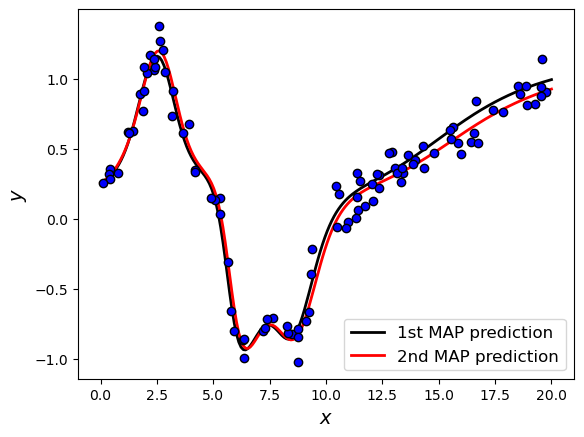

In [4]:
# define the log-posterior function
def logposterior_estimator_fn(logprior_fn, loglikelihood_fn, data_size: int):
    """Log posterior function"""

    def logposterior_fn(parameters, data_batch):
        logprior = logprior_fn(parameters)
        batch_loglikelihood = jax.vmap(loglikelihood_fn, in_axes=(None, 0))
        return logprior + data_size * jnp.mean(
            batch_loglikelihood(parameters, data_batch), axis=0
        )

    return logposterior_fn


logposterior_fn = logposterior_estimator_fn(logprior_fn, loglikelihood_fn, len(X))
train_ds = dict(x=X, y=y)

# train a first network to get centering parameters that will be used for control variates
key = jr.PRNGKey(np.random.randint(low=0, high=12345))

map_params = train_fn(logposterior_fn, network(), train_ds, 32, 10_000, 1e-2, key)
map_pred_test_1 = network().apply({"params": map_params}, X_test)
mse = jnp.mean((map_pred_test_1 - y_test) ** 2)

# train a second network to get initial parameters for the SGMCMC algorithms
_, key = jr.split(key)
init_params = train_fn(logposterior_fn, network(), train_ds, 32, 10_000, 1e-2, key)
map_pred_test_2 = network().apply({"params": init_params}, X_test)

# also generate random initial positions that will be used for some algorithms
_, key = jr.split(key)
rng_init_positions = network().init(key, X_test[0])["params"]

# sanity check: plot the associated predictions
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(X_test, map_pred_test_1, ls="-", lw=2, color="k", label="1st MAP prediction")
ax.plot(X_test, map_pred_test_2, ls="-", lw=2, color="r", label="2nd MAP prediction")
# ax.plot(X_test, rng_pred_test, ls="-", lw=2, color="m", label="Random network")
ax.plot(
    X, y, ls="", marker="o", markerfacecolor="b", markeredgecolor="k", markeredgewidth=1
)
ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y$", fontsize=14)
ax.legend(fontsize=12)

### MCMC algorithms

#### Define a helper function for SGMCMC methods

In [5]:
# global parameters
batch_size = 32


def sgmcmc_fn(algorithm, burnin, thin_freq, init_positions, rng_key, **kwargs):
    keys = jr.split(rng_key)
    positions, ravel_fn, predict_fn = algorithm(
        X=X,
        y=y,
        loglikelihood_fn=loglikelihood_fn,
        logprior_fn=logprior_fn,
        init_positions=init_positions,
        batch_size=batch_size,
        rng_key=keys[0],
        **kwargs,
    )

    # remove burnin and thin
    positions = jax.tree_util.tree_map(lambda xx: xx[burnin::thin_freq], positions)

    # predict
    f_predictions = predict_fn(network, positions, X_test).squeeze()

    # generate the noisy predictions
    _, key = jr.split(keys[11])
    y_predictions = f_predictions + noise_level * jr.normal(
        key, shape=(len(f_predictions), 1)
    )

    return ravel_fn(positions), y_predictions

#### Set some hyperparameters

In [6]:
algorithms = [
    (
        sgld,
        {
            "step_size": 1e-8,
            "num_iterations": 100_000,
            "burnin": 80_000,
            "thin_freq": 10,
            "init_positions": init_params,
        },
    ),
    (
        pSGLD,
        {
            "step_size": 5e-5,
            "preconditioning_factor": 0.95,
            "num_iterations": 100_000,
            "burnin": 80_000,
            "thin_freq": 10,
            "init_positions": rng_init_positions,
        },
    ),
    (
        cyclical_sgld,
        {
            "step_size": 1e-6,
            "num_cycles": 5,
            "num_sgd_steps": 1_00,
            "num_sgld_steps": 20_000,
            "burnin_sgld": 10_000,
            "burnin": 0,
            "thin_freq": 10,
            "init_positions": init_params,
        },
    ),
    (
        sgld_cv,
        {
            "step_size": 1e-7,
            "num_iterations": 10_000,
            "burnin": 5_000,
            "thin_freq": 10,
            "centering_positions": map_params,
            "init_positions": map_params,
        },
    ),
    (
        sgld_svrg,
        {
            "step_size": 2e-6,
            "num_cv_iterations": 10,
            "num_svrg_iterations": 2000,
            "burnin": 10_000,
            "thin_freq": 10,
            "centering_positions": map_params,
            "init_positions": map_params,
        },
    ),
    (
        sghmc,
        {
            "step_size": 5e-5,
            "num_integration_steps": 100,
            "num_iterations": 2_000,
            "burnin": 1_000,
            "thin_freq": 10,
            "init_positions": init_params,
        },
    ),
    (
        sghmc_cv,
        {
            "step_size": 5e-5,
            "num_iterations": 10_000,
            "burnin": 5_000,
            "thin_freq": 10,
            "centering_positions": map_params,
            "num_integration_steps": 40,
            "init_positions": map_params,
        },
    ),
    (
        sghmc_svrg,
        {
            "step_size": 5e-5,
            "num_cv_iterations": 10,
            "num_svrg_iterations": 2000,
            "burnin": 10_000,
            "thin_freq": 10,
            "centering_positions": map_params,
            "num_integration_steps": 40,
            "init_positions": map_params,
        },
    ),
]

#### Run SGMCMC methods

In [7]:
# Create an empty dict for storing predictions
y_predictions = dict(
    sgld=None,
    pSGLD=None,
    sgld_cv=None,
    sgld_svrg=None,
    sghmc=None,
    sghmc_cv=None,
    sghmc_svrg=None,
    cyclical_sgld=None,
    hmc=None,
)

for algorithm, hparams in algorithms:
    _, key = jr.split(key)
    burnin, thin_freq, init_pos = (
        hparams["burnin"],
        hparams["thin_freq"],
        hparams["init_positions"],
    )
    hparams.pop("burnin")
    hparams.pop("thin_freq")
    hparams.pop("init_positions")
    t0 = time()
    positions, y_prediction = sgmcmc_fn(
        algorithm, burnin, thin_freq, init_pos, key, **hparams
    )
    print(f"Elapsed time for {algorithm.__name__}: {time()-t0}")
    y_predictions[algorithm.__name__] = y_prediction

Elapsed time for sgld: 9.930523157119751
Elapsed time for pSGLD: 11.697723627090454
Elapsed time for cyclical_sgld: 12.502580881118774
Elapsed time for sgld_cv: 2.9192466735839844
Elapsed time for sgld_svrg: 4.193420648574829
Elapsed time for sghmc: 22.310141563415527
Elapsed time for sghmc_cv: 39.58222699165344
Elapsed time for sghmc_svrg: 82.1585681438446


#### Run HMC

In [8]:
def logprob_fn(parameters):
    logprior = logprior_fn(parameters)
    batch_loglikelihood = jax.vmap(loglikelihood_fn, (None, 0))(parameters, (X, y))
    return logprior + jnp.sum(batch_loglikelihood)


_, key = jr.split(key)
t0 = time()
positions, ravel_fn, predict_fn = hmc(
    logprob_fn=logprob_fn,
    init_positions=init_params,
    num_samples=200,
    step_size=1e-4,
    inverse_mass_matrix=jnp.ones(positions.shape[1]),
    num_integration_steps=40,
    rng_key=key,
)
print(f"Elapsed time for HMC: {time()-t0}")

# predict
f_predictions = predict_fn(network, positions, X_test).squeeze()

# generate the noisy predictions
_, key = jr.split(key)
hmc_predictions = f_predictions + noise_level * jr.normal(
    key, shape=(len(f_predictions), 1)
)
y_predictions["hmc"] = hmc_predictions

Elapsed time for HMC: 2.103886842727661


#### Plot the prediction intervals

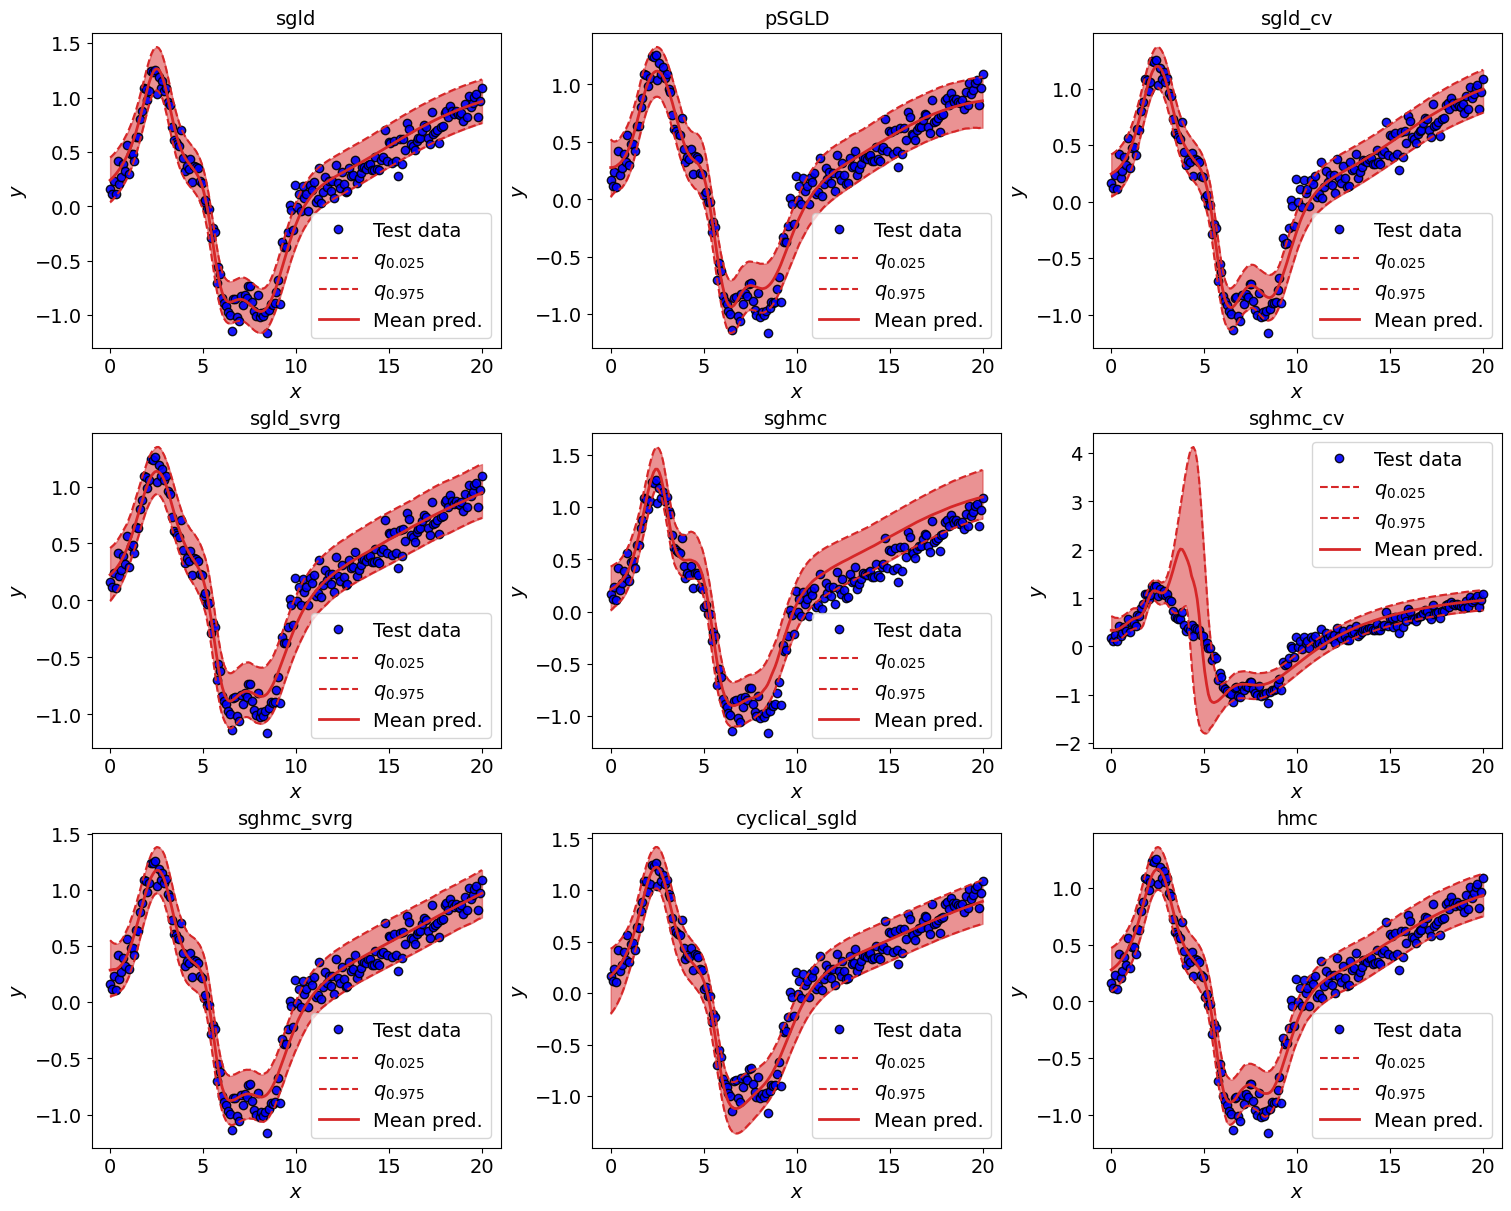

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(3 * 5, 3 * 4))
gs = GridSpec(nrows=3, ncols=3, figure=fig)
alpha = 0.05

for i, (name, y_pred) in enumerate(y_predictions.items()):
    mean_prediction = jnp.median(y_pred, axis=0)
    qlow = jnp.quantile(y_pred, 0.5 * alpha, axis=0)
    qhigh = jnp.quantile(y_pred, (1 - 0.5 * alpha), axis=0)

    ax = fig.add_subplot(gs[i])
    plot_on_axis(ax, X_test, y_test, mean_prediction, qlow, qhigh, title=f"{name}")

## Deep ensembles

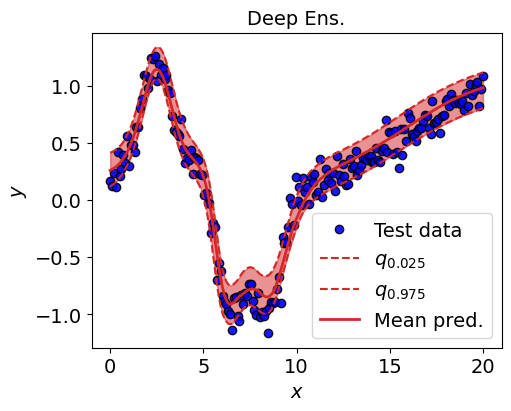

In [10]:
key = jr.PRNGKey(np.random.randint(low=0, high=12345))

positions, ravel_fn, predict_fn = deep_ensembles_fn(
    X, y, loglikelihood_fn, logprior_fn, network, batch_size, 10_000, 1e-2, 10, key
)

f_predictions = predict_fn(network, positions, X_test).squeeze()

key = jr.PRNGKey(np.random.randint(low=0, high=12345))
y_predictions = f_predictions + noise_level * jr.normal(
    key, shape=(len(f_predictions), 1)
)

fig = plt.figure(constrained_layout=True, figsize=(1 * 5, 1 * 4))
gs = GridSpec(nrows=1, ncols=1, figure=fig)

mean_prediction = jnp.median(y_predictions, axis=0)
qlow = jnp.quantile(y_predictions, 0.5 * alpha, axis=0)
qhigh = jnp.quantile(y_predictions, (1 - 0.5 * alpha), axis=0)

ax = fig.add_subplot(gs[0])
plot_on_axis(ax, X_test, y_test, mean_prediction, qlow, qhigh, title="Deep Ens.")

## SWAG

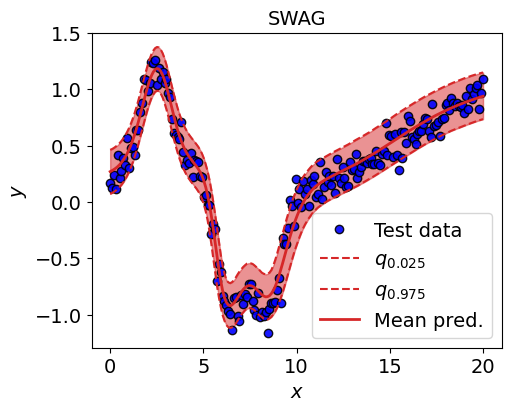

In [11]:
key = jr.PRNGKey(np.random.randint(low=0, high=12345))

positions, ravel_fn, predict_fn = swag_fn(
    X,
    y,
    loglikelihood_fn,
    logprior_fn,
    network,
    map_params,
    batch_size,
    1000,
    1e-5,
    20,
    key,
)

f_predictions = predict_fn(network, positions, X_test)

key = jr.PRNGKey(np.random.randint(low=0, high=12345))
y_predictions = f_predictions + noise_level * jr.normal(
    key, shape=(len(f_predictions), 1)
)

fig = plt.figure(constrained_layout=True, figsize=(1 * 5, 1 * 4))
gs = GridSpec(nrows=1, ncols=1, figure=fig)

alpha = 0.05
mean_prediction = jnp.median(y_predictions, axis=0)
qlow = jnp.quantile(y_predictions, 0.5 * alpha, axis=0)
qhigh = jnp.quantile(y_predictions, (1 - 0.5 * alpha), axis=0)

ax = fig.add_subplot(gs[0])
plot_on_axis(ax, X_test, y_test, mean_prediction, qlow, qhigh, title="SWAG")

## Monte Carlo dropout

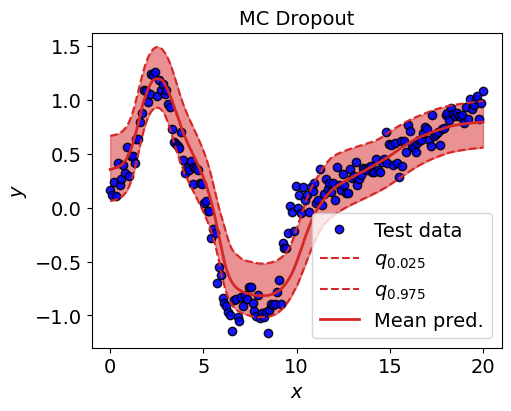

In [12]:
dropout_rate = 0.05


class network_dropout(nn.Module):
    """Simple MLP."""

    @nn.compact
    def __call__(self, x, deterministic=False):
        x = nn.Dense(
            features=50,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.Dropout(dropout_rate, deterministic=deterministic)(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=50,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.Dropout(dropout_rate, deterministic=deterministic)(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=1,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        return x


def loglikelihood_fn_dropout(
    parameters, data, dropout_rng, sig_noise: float = noise_level
):
    """Gaussian log-likelihood"""
    X, y = data
    return -jnp.sum(
        0.5
        * (
            y
            - network_dropout().apply(
                {"params": parameters}, X, rngs={"dropout": dropout_rng}
            )
        )
        ** 2
        / sig_noise**2
    )


key = jr.PRNGKey(np.random.randint(low=0, high=12345))

positions, ravel_fn, predict_fn = mcdropout_fn(
    X,
    y,
    loglikelihood_fn_dropout,
    logprior_fn,
    network_dropout,
    batch_size,
    10_000,
    1e-2,
    key,
)

key = jr.PRNGKey(np.random.randint(low=0, high=12345))
keys = jr.split(key, 100)

f_predictions = jnp.stack(
    [predict_fn(network_dropout, positions, X_test, key) for key in keys]
).squeeze()

_, key = jr.split(keys[-1])
y_predictions = f_predictions + noise_level * jr.normal(
    key, shape=(len(f_predictions), 1)
)

fig = plt.figure(constrained_layout=True, figsize=(1 * 5, 1 * 4))
gs = GridSpec(nrows=1, ncols=1, figure=fig)

alpha = 0.05
mean_prediction = jnp.median(y_predictions, axis=0)
qlow = jnp.quantile(y_predictions, 0.5 * alpha, axis=0)
qhigh = jnp.quantile(y_predictions, (1 - 0.5 * alpha), axis=0)

ax = fig.add_subplot(gs[0])
plot_on_axis(ax, X_test, y_test, mean_prediction, qlow, qhigh, title="MC Dropout")

In [13]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Brian Staber'

Author: Brian Staber

Last updated: Mon Feb 26 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

blackjax  : 1.1.0
numpy     : 1.26.3
matplotlib: 3.8.2
flax      : 0.8.0
jax       : 0.4.23

Watermark: 2.4.3

